##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learning to Rank with Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/ranking_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


Welcome to the **Learning to Rank Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn how to use **TF-DF** for ranking.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Learn what a ranking model is.
1. Train a Gradient Boosted Trees models on the LETOR3 dataset.
1. Evaluate the quality of this model.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [2]:
!pip install tensorflow_decision_forests
# TF-DF requires Tensorflow < 2.15 or tf_keras
!pip install tf_keras


  Using cached tensorflow_decision_forests-1.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)


  Using cached wurlitzer-3.0.3-py3-none-any.whl (7.3 kB)


Using cached tensorflow_decision_forests-1.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.3 MB)


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

## Importing libraries

In [4]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import math

2024-01-31 12:09:40.640091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 12:09:40.640135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 12:09:40.641564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The hidden code cell limits the output height in colab.


In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.8.1


## What is a ranking model?

The goal of a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model is to **correctly order** items. For example, ranking can be used to select the best *documents* to retrieve following a user *query*.

A common way to represent a Ranking dataset is with a "relevance" score: The order of the elements is defined by their relevance: Items of greater relevance should be before lower relevance items. The cost of a mistake is defined by the difference between the relevance of the predicted item with the relevance of the correct item. For example, misordering two items with respective relevance 3 and 4 is not as bad as misordering two items with respective relevance 1 and 5.

TF-DF expects ranking datasets to be presented in a "flat" format.
A dataset of queries and corresponding documents might look like this:

query | document_id | feature_1 | feature_2 | relevance
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 0
dog   | 6           | 0.6       | green     | 1


The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "same as the query".

In this example, Document 1 is very relevant to the query "cat", while document 2 is only "related" to cats. There are no documents is really talking about "dog" (the highest relevance is 1 for the document 6). However, the dog query is still expecting to return document 6 (since this is the document that talks the "most" about dogs).

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.

## Let's train a Ranking model

In this example, use a sample of the
[LETOR3](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-3-0)
dataset. More precisely, we want to download the `OHSUMED.zip` from [the LETOR3 repo](https://onedrive.live.com/?authkey=%21ACnoZZSZVfHPJd0&id=8FEADC23D838BDA8%21107&cid=8FEADC23D838BDA8). This dataset is stored in the
libsvm format, so we will need to convert it to csv.

In [7]:
archive_path = tf_keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to a ranking ataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/Fold1/trainingset.txt")

    8192/61824018 [..............................] - ETA: 0s

 2334720/61824018 [>.............................] - ETA: 1s

 9756672/61824018 [===>..........................] - ETA: 0s

17424384/61824018 [=======>......................] - ETA: 0s

25624576/61824018 [===========>..................] - ETA: 0s

32309248/61824018 [==============>...............] - ETA: 0s

39116800/61824018 [=================>............] - ETA: 0s

46145536/61824018 [=====================>........] - ETA: 0s

54853632/61824018 [=========================>....] - ETA: 0s

61145088/61824018 [============================>.] - ETA: 0s

61824018/61824018 [==============================] - 0s 0us/step


Here are the first lines of the dataset:

In [8]:
!head {raw_dataset_path}

The first step is to convert this dataset to the "flat" format mentioned above.

In [9]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In this dataset, each row represents a pair of query/document (called "group"). The "relevance" tells how much the query matches the document.

The features of the query and the document are merged together in "f1-25". The exact definition of the features is not known, but it would be omething like:

- Number of words in queries
- Number of common words between the query and the document
- Cosinus similarity between an embedding of the query and an embedding of the document.
- ...

Let's convert the Pandas Dataframe into a TensorFlow Dataset:

In [10]:
dataset_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="relevance", task=tfdf.keras.Task.RANKING)

Let's configure and train our Ranking model.

In [11]:
%set_cell_height 400

model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,
    ranking_group="group",
    num_trees=50)

model.fit(dataset_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmps8z5naxq as temporary training directory


Reading training dataset...


[WARNING 24-01-31 12:09:47.9677 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-31 12:09:47.9677 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-31 12:09:47.9677 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:03.787268. Found 9219 examples.


Training model...


Model trained in 0:00:00.744883


Compiling model...


[INFO 24-01-31 12:09:52.5221 UTC kernel.cc:1233] Loading model from path /tmpfs/tmp/tmps8z5naxq/model/ with prefix 13431959a63d4d94
[INFO 24-01-31 12:09:52.5233 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-01-31 12:09:52.5234 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-01-31 12:09:52.5234 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


We can now look at the quality of the model on the validation dataset. By default, TF-DF trains ranking models to optimize the [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). The NDCG is a value between 0 and 1, where 1 is the perfect score. For this reason, -NDCG is the model loss.

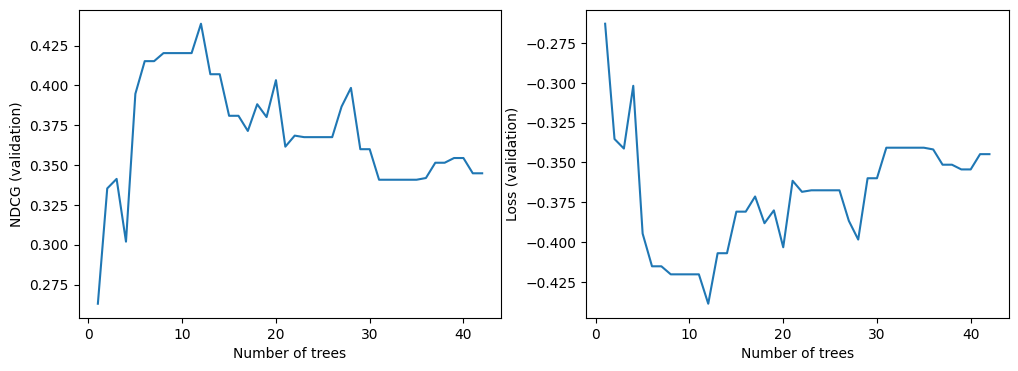

In [12]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.ndcg for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("NDCG (validation)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Loss (validation)")

plt.show()

As for all TF-DF models, you can also look at the model report (Note: The model report also contains the training logs):

In [13]:
%set_cell_height 400
model.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


Total params: 1 (1.00 Byte)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 1 (1.00 Byte)


_________________________________________________________________


Type: "GRADIENT_BOOSTED_TREES"
Task: RANKING
Label: "__LABEL"
Rank group: "group"

Input Features (25):
	f_1
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_2
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_3
	f_4
	f_5
	f_6
	f_7
	f_8
	f_9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "f_9"  0.326164 ################
    2.  "f_3"  0.318071 ###############
    3.  "f_8"  0.308922 #############
    4.  "f_4"  0.271175 #########
    5. "f_19"  0.221570 ###
    6. "f_10"  0.215666 ##
    7. "f_11"  0.206509 #
    8. "f_22"  0.204742 #
    9. "f_25"  0.204497 #
   10. "f_23"  0.203238 
   11. "f_21"  0.200830 
   12. "f_24"  0.200445 
   13. "f_12"  0.198840 
   14. "f_18"  0.197676 
   15. "f_20"  0.196634 
   16.  "f_6"  0.196085 
   17. "f_16"  0.196061 
   18.  "f_2"  0.195683 
   19.  "f_5"  0.195683 
   20. "f_13"  0.195559 
   21. "f_17"  0.195559 

Variable Importance: NUM_AS_ROOT:
    1. "f_3"  4.000000 ################
    2. "f_4"  4.000000 ################


And if you are curious, you can also plot the model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

## Predicting with a ranking model

For an incoming query, we can use our ranking model to predict the relevance of
a stack of documents. In practice this means that for each query, we must come
up with a set of documents that may or may not be relevant to the query. We call
these documents our **candidate documents**. For each pair
query/candidate document, we can compute the same features used during training.
This is our **serving dataset**.

Going back to the example from the beginning of this tutorial, the serving
dataset might look like this:

query  | document_id | feature_1 | feature_2
------ | ----------- | --------- | --------- 
fish   | 32          | 0.3       | blue     
fish   | 33          | 1.0       | green     
fish   | 34          | 0.4       | blue       
fish   | 35          | NA        | brown       

Observe that *relevance* is not part of the serving dataset, since this is what
the model is trying to predict.

The serving dataset is fed to the TF-DF model and assigns a relevance score to
each document.

query  | document_id | feature_1 | feature_2 | relevance
------ | ----------- | --------- | --------- | ---------
fish   | 32          | 0.3       | blue      | 0.325
fish   | 33          | 1.0       | green     | 0.125
fish   | 34          | 0.4       | blue      | 0.155
fish   | 35          | NA        | brown     | 0.593

This means that the document with document_id 35 is predicted to be most
relevant for query "fish".

Let's try to do this with our real model.

In [15]:
# Path to a test dataset using libsvm format.
test_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/Fold1/testset.txt")
# Convert the dataset.
csv_test_dataset_path="/tmp/ohsumed_test.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_test_dataset_path)

# Load a dataset into a Pandas Dataframe.
test_dataset_df = pd.read_csv(csv_test_dataset_path)

# Display the first 3 examples.
test_dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


Suppose our query is "g_5" and the test dataset already contains the candidate
documents for this query.

In [16]:
# Filter by "g_5"
serving_dataset_df = test_dataset_df[test_dataset_df['group'] == 'g_5']
# Remove the columns for group and relevance, not needed for predictions.
serving_dataset_df = serving_dataset_df.drop(['relevance', 'group'], axis=1)
# Convert to a Tensorflow dataset
serving_dataset_ds = tfdf.keras.pd_dataframe_to_tf_dataset(serving_dataset_df, task=tfdf.keras.Task.RANKING)

In [17]:
# Run predictions with on all candidate documents
predictions = model.predict(serving_dataset_ds)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 172ms/step


We can use add the predictions to the dataframe and use them to find the 
documents with the highest scores. 

In [18]:
serving_dataset_df['prediction_score'] = predictions
serving_dataset_df.sort_values(by=['prediction_score'], ascending=False).head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,prediction_score
642,2.0,1.386294,0.666667,0.575364,29.447117,8.435116,29.448021,2.207135,12.292170,10.101899,...,21.208715,0.523845,77.852148,7.659101,30.2660,3.410025,-3.03908,-3.19282,-2.87112,0.965342
685,3.0,2.079442,0.750000,0.669431,29.447117,8.435116,29.448021,3.060164,21.795657,17.652746,...,21.208715,0.793681,39.623271,8.513801,33.9830,3.525860,-2.84235,-2.81360,-2.59920,0.893874
646,4.0,2.772589,0.285714,0.275971,29.447117,8.435116,29.448021,1.421063,24.550338,14.727974,...,21.208715,0.602963,84.868108,7.767931,31.0268,3.434851,-3.19269,-3.31166,-3.14901,0.258856
684,4.0,2.484907,0.333333,0.314236,29.447117,8.435116,29.448021,1.730304,29.299744,15.114793,...,21.208715,0.692899,71.279648,8.148804,36.5645,3.599078,-2.16625,-2.43823,-1.94658,0.258856
640,3.0,2.079442,0.428571,0.400594,29.447117,8.435116,29.448021,2.107361,21.795657,15.999891,...,21.208715,0.000000,0.000000,0.000000,30.6422,3.422378,-3.20997,-2.59768,-2.59768,0.258856
